In [2]:
# import libraries
import os
import glob
import shutil
import zipfile
import io
import warnings
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
import opensmile
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

print("Libraries uploaded successfully")

Libraries uploaded successfully


In [4]:
# data uploading and preparation
def get_ai4ser_label(path_str):
    p = path_str.lower()
    
    # 0: anger
    if 'rab' in p or 'ang' in p: return 0
    # 1: joy
    if 'gio' in p or 'joy' in p or 'hap' in p or 'fel' in p: return 1
    # 2: neutral
    if 'neu' in p: return 2
    # 3: sadness
    if 'tri' in p or 'sad' in p: return 3
    # 4: fear
    if 'pau' in p or 'fear' in p or 'fea' in p: return 4
    
    return None

def prepare_data():
    data_records = []
    

    print("\n--- 1. Processing AI4SER ---")
    
    if os.path.exists("data/ai4ser"): shutil.rmtree("data/ai4ser")
    os.makedirs("data/ai4ser", exist_ok=True)
    
    parquet_files = glob.glob("*.parquet")
    if parquet_files:
        global_count = 0
        counts = {0:0, 1:0, 2:0, 3:0, 4:0}
        
        for p_file in parquet_files:
            try:
                df_p = pd.read_parquet(p_file)
                for _, row in tqdm(df_p.iterrows(), total=len(df_p), desc=f"Reading {p_file}"):
                    original_path = row['audio'].get('path', '')
                    label_id = get_ai4ser_label(original_path)
                    
                    if label_id is not None:
                        file_path = f"data/ai4ser/ai4ser_{global_count}.wav"
                        
                        if 'bytes' in row['audio']:
                            y, sr = sf.read(io.BytesIO(row['audio']['bytes']))
                            sf.write(file_path, y, sr)
                            
                            data_records.append({'path': file_path, 'label': label_id, 'dataset': 'AI4SER'})
                            counts[label_id] += 1
                            global_count += 1
            except Exception as e: print(f"Err {p_file}: {e}")
        
        print(f"AI4SER Completato: {global_count} file.")
        print(f"   Dettaglio: Ang={counts[0]}, Joy={counts[1]}, Neu={counts[2]}, Sad={counts[3]}, Fear={counts[4]}")
    else:
        print("Nessun file .parquet trovato.")

    print("\n--- 2. Processing EMOZIONALMENTE ---")
    zip_path = "emozionalmente.zip"
    extract_path = "data/emozionalmente"
    
    if os.path.exists(zip_path) and not os.path.exists(extract_path):
        with zipfile.ZipFile(zip_path, 'r') as z: z.extractall(extract_path)
    
    csv_path = os.path.join(extract_path, "metadata", "samples.csv")
    audio_dir = os.path.join(extract_path, "audio")
    
    EMOZ_MAP = {'anger': 0, 'rabbia': 0, 'joy': 1, 'happiness': 1, 'gioia': 1, 
                'neutral': 2, 'neutro': 2, 'sadness': 3, 'tristezza': 3, 'fear': 4, 'paura': 4}

    if os.path.exists(csv_path):
        try:
            df_meta = pd.read_csv(csv_path)
            df_meta.columns = [c.lower().strip() for c in df_meta.columns]
            
            col_file = next((c for c in df_meta.columns if c in ['file_name', 'filename']), None)
            col_emo = next((c for c in df_meta.columns if c in ['emotion_expressed', 'emotion']), None)
            
            count_emoz = 0
            if col_file and col_emo:
                for _, row in df_meta.iterrows():
                    fname = str(row[col_file])
                    raw_emo = str(row[col_emo]).lower().strip()
                    
                    if raw_emo in EMOZ_MAP:
                        full_path = os.path.join(audio_dir, fname)
                        if os.path.exists(full_path):
                            data_records.append({'path': full_path, 'label': EMOZ_MAP[raw_emo], 'dataset': 'EMOZIONALMENTE'})
                            count_emoz += 1
            print(f"EMOZIONALMENTE Completato: {count_emoz} file.")
        except Exception as e: print(f"Err CSV: {e}")
    else:
        print("CSV Metadata non trovato.")

    return pd.DataFrame(data_records)

df_full = prepare_data()
if not df_full.empty:
    print("\n" + "="*40)
    print(f"DATASET TOTALE: {len(df_full)} file")
    print(df_full['dataset'].value_counts())
    print("="*40)


--- 1. Processing AI4SER ---


Reading 0001.parquet:   0%|          | 0/800 [00:00<?, ?it/s]

Reading 0000.parquet:   0%|          | 0/2700 [00:00<?, ?it/s]

AI4SER Completato: 2500 file.
   Dettaglio: Ang=500, Joy=500, Neu=500, Sad=500, Fear=500

--- 2. Processing EMOZIONALMENTE ---
EMOZIONALMENTE Completato: 3944 file.

DATASET TOTALE: 6444 file
dataset
EMOZIONALMENTE    3944
AI4SER            2500
Name: count, dtype: int64


In [5]:
# feature extraction

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

def extract_mfcc(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000, duration=4.0)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return np.hstack([np.mean(mfcc, axis=1), np.std(mfcc, axis=1)])
    except: return None

def extract_egemaps(file_path):
    try:
        return smile.process_file(file_path).values.flatten()
    except: return None

print("Inizio estrazione feature...")
X_mfcc, X_egemaps, y_labels, groups = [], [], [], []

for _, row in tqdm(df_full.iterrows(), total=len(df_full), desc="Processing"):
    f1 = extract_mfcc(row['path'])
    f2 = extract_egemaps(row['path'])
    
    if f1 is not None and f2 is not None:
        X_mfcc.append(f1)
        X_egemaps.append(f2)
        y_labels.append(row['label'])
        groups.append(row['dataset'])

X_mfcc = np.array(X_mfcc)
X_egemaps = np.array(X_egemaps)
y = np.array(y_labels)
groups = np.array(groups)

print(f"\n Feature pronte. MFCC: {X_mfcc.shape}, eGeMAPS: {X_egemaps.shape}")

Inizio estrazione feature...


Processing:   0%|          | 0/6444 [00:00<?, ?it/s]


 Feature pronte. MFCC: (6444, 26), eGeMAPS: (6444, 88)


In [6]:
# model definition and experiment logic

def run_experiment(X, y, group_labels, scenario, model_type='svm'):
    
    if model_type == 'svm':
        clf = SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=42)
        
    elif model_type == 'mlp':
        clf = MLPClassifier(hidden_layer_sizes=(256, 128), 
                            activation='relu', solver='adam', 
                            learning_rate='adaptive', max_iter=500, 
                            early_stopping=True, random_state=42)
    
    scaler = StandardScaler()
    results = {'y_true': [], 'y_pred': []}
    
    print(f"⚙️ Running: {scenario} | {model_type.upper()} ...")

    # A. INTRA-DATASET & COMBINED (5-Fold CV)
    if scenario in ['AI4SER', 'EMOZIONALMENTE', 'COMBINED']:
        if scenario != 'COMBINED':
            mask = group_labels == scenario
            X_curr, y_curr = X[mask], y[mask]
        else:
            X_curr, y_curr = X, y

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for train_idx, test_idx in skf.split(X_curr, y_curr):
            X_train, X_test = X_curr[train_idx], X_curr[test_idx]
            y_train, y_test = y_curr[train_idx], y_curr[test_idx]
            
            scaler.fit(X_train)
            X_train_s = scaler.transform(X_train)
            X_test_s = scaler.transform(X_test)
            
            clf.fit(X_train_s, y_train)
            
            preds = clf.predict(X_test_s)
            
            results['y_true'].extend(y_test)
            results['y_pred'].extend(preds)

    # B. CROSS-DATASET
    elif scenario == 'CROSS':
        mask_a = group_labels == 'AI4SER'
        mask_b = group_labels == 'EMOZIONALMENTE'
        
        # 1. Train AI4SER -> Test EMOZ
        scaler.fit(X[mask_a])
        clf.fit(scaler.transform(X[mask_a]), y[mask_a])
        pred_b = clf.predict(scaler.transform(X[mask_b]))
        results['A_to_B'] = {'y_true': y[mask_b], 'y_pred': pred_b}
        
        # 2. Train EMOZ -> Test AI4SER
        scaler.fit(X[mask_b])
        clf.fit(scaler.transform(X[mask_b]), y[mask_b])
        pred_a = clf.predict(scaler.transform(X[mask_a]))
        results['B_to_A'] = {'y_true': y[mask_a], 'y_pred': pred_a}

    return results

def plot_cm(y_true, y_pred, title):
    LABELS = [0, 1, 2, 3, 4]
    NAMES = ['Ang', 'Joy', 'Neu', 'Sad', 'Fear']
    
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    
    print(f"\n--- REPORT: {title} (Acc: {acc:.2f}) ---")
    print(classification_report(y_true, y_pred, labels=LABELS, target_names=NAMES, zero_division=0))
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=NAMES, yticklabels=NAMES)
    plt.title(title)
    plt.ylabel('True'); plt.xlabel('Predicted')
    plt.show()

SCENARIO 1: INTRA-DATASET (5-Fold CV)

⚙️ Running: AI4SER | SVM ...

--- REPORT: INTRA: AI4SER | MFCC | SVM (Acc: 0.70) ---
              precision    recall  f1-score   support

         Ang       0.65      0.65      0.65       500
         Joy       0.68      0.67      0.67       500
         Neu       0.73      0.79      0.76       500
         Sad       0.78      0.74      0.76       500
        Fear       0.65      0.62      0.64       500

    accuracy                           0.70      2500
   macro avg       0.70      0.70      0.70      2500
weighted avg       0.70      0.70      0.70      2500



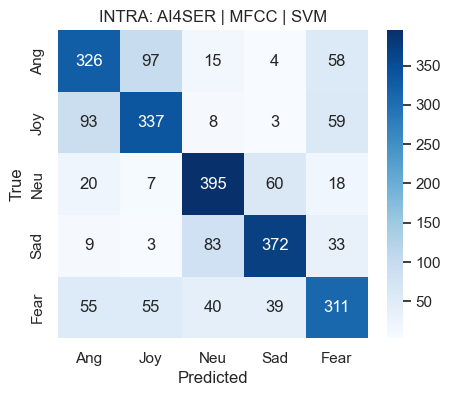

⚙️ Running: AI4SER | MLP ...

--- REPORT: INTRA: AI4SER | MFCC | MLP (Acc: 0.67) ---
              precision    recall  f1-score   support

         Ang       0.62      0.62      0.62       500
         Joy       0.66      0.63      0.65       500
         Neu       0.74      0.76      0.75       500
         Sad       0.73      0.72      0.73       500
        Fear       0.58      0.61      0.60       500

    accuracy                           0.67      2500
   macro avg       0.67      0.67      0.67      2500
weighted avg       0.67      0.67      0.67      2500



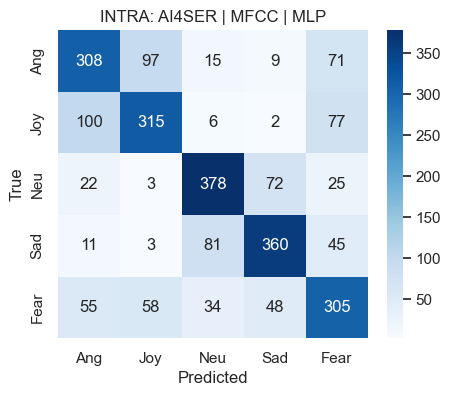

⚙️ Running: AI4SER | SVM ...

--- REPORT: INTRA: AI4SER | eGeMAPS | SVM (Acc: 0.72) ---
              precision    recall  f1-score   support

         Ang       0.69      0.75      0.72       500
         Joy       0.73      0.67      0.70       500
         Neu       0.74      0.80      0.77       500
         Sad       0.76      0.75      0.76       500
        Fear       0.69      0.64      0.67       500

    accuracy                           0.72      2500
   macro avg       0.72      0.72      0.72      2500
weighted avg       0.72      0.72      0.72      2500



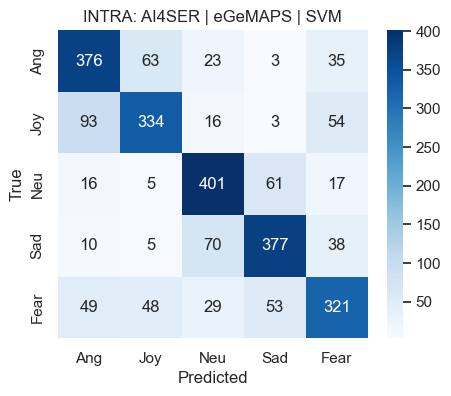

⚙️ Running: AI4SER | MLP ...

--- REPORT: INTRA: AI4SER | eGeMAPS | MLP (Acc: 0.71) ---
              precision    recall  f1-score   support

         Ang       0.71      0.71      0.71       500
         Joy       0.68      0.68      0.68       500
         Neu       0.74      0.79      0.76       500
         Sad       0.76      0.73      0.74       500
        Fear       0.68      0.66      0.67       500

    accuracy                           0.71      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.71      0.71      0.71      2500



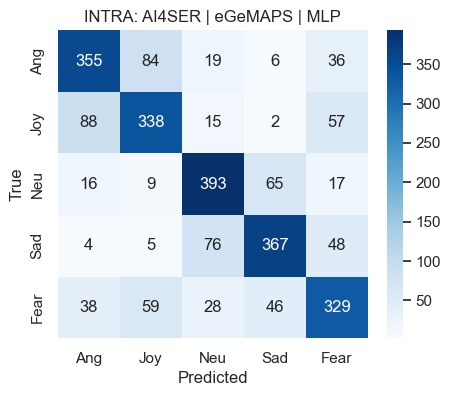

⚙️ Running: EMOZIONALMENTE | SVM ...

--- REPORT: INTRA: EMOZIONALMENTE | MFCC | SVM (Acc: 0.54) ---
              precision    recall  f1-score   support

         Ang       0.55      0.54      0.55       986
         Joy       0.53      0.56      0.54       986
         Neu       0.00      0.00      0.00         0
         Sad       0.57      0.64      0.61       986
        Fear       0.49      0.42      0.45       986

    accuracy                           0.54      3944
   macro avg       0.43      0.43      0.43      3944
weighted avg       0.54      0.54      0.54      3944



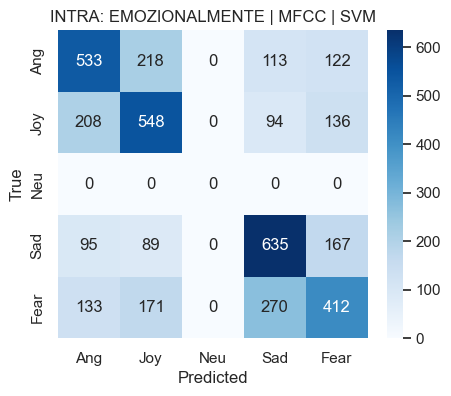

⚙️ Running: EMOZIONALMENTE | MLP ...

--- REPORT: INTRA: EMOZIONALMENTE | MFCC | MLP (Acc: 0.52) ---
              precision    recall  f1-score   support

         Ang       0.54      0.53      0.53       986
         Joy       0.52      0.55      0.53       986
         Neu       0.00      0.00      0.00         0
         Sad       0.54      0.63      0.58       986
        Fear       0.47      0.37      0.41       986

    accuracy                           0.52      3944
   macro avg       0.41      0.42      0.41      3944
weighted avg       0.52      0.52      0.51      3944



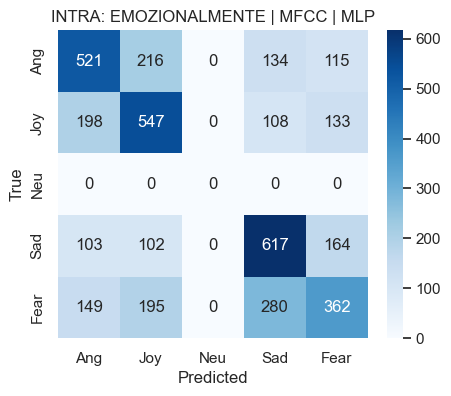

⚙️ Running: EMOZIONALMENTE | SVM ...

--- REPORT: INTRA: EMOZIONALMENTE | eGeMAPS | SVM (Acc: 0.61) ---
              precision    recall  f1-score   support

         Ang       0.61      0.62      0.61       986
         Joy       0.66      0.61      0.63       986
         Neu       0.00      0.00      0.00         0
         Sad       0.60      0.69      0.64       986
        Fear       0.57      0.52      0.55       986

    accuracy                           0.61      3944
   macro avg       0.49      0.49      0.49      3944
weighted avg       0.61      0.61      0.61      3944



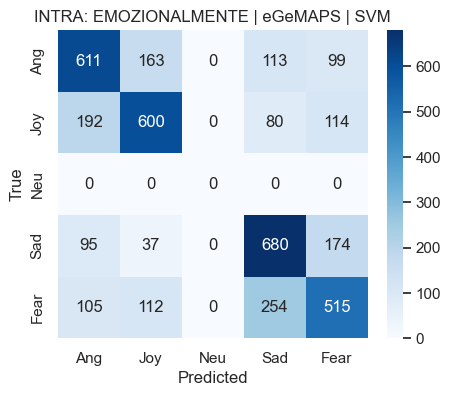

⚙️ Running: EMOZIONALMENTE | MLP ...

--- REPORT: INTRA: EMOZIONALMENTE | eGeMAPS | MLP (Acc: 0.62) ---
              precision    recall  f1-score   support

         Ang       0.62      0.59      0.60       986
         Joy       0.62      0.66      0.64       986
         Neu       0.00      0.00      0.00         0
         Sad       0.62      0.71      0.66       986
        Fear       0.59      0.50      0.54       986

    accuracy                           0.62      3944
   macro avg       0.49      0.49      0.49      3944
weighted avg       0.61      0.62      0.61      3944



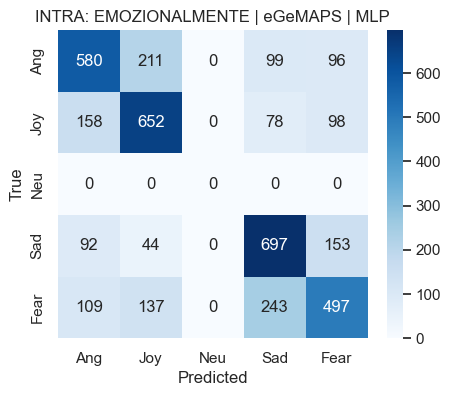

SCENARIO 2: CROSS-DATASET (eGeMAPS only)

⚙️ Running: CROSS | SVM ...

--- REPORT: CROSS: AI4SER->EMOZ | eGeMAPS | SVM (Acc: 0.35) ---
              precision    recall  f1-score   support

         Ang       0.37      0.19      0.25       986
         Joy       0.46      0.24      0.32       986
         Neu       0.00      0.00      0.00         0
         Sad       0.47      0.40      0.43       986
        Fear       0.30      0.57      0.39       986

    accuracy                           0.35      3944
   macro avg       0.32      0.28      0.28      3944
weighted avg       0.40      0.35      0.35      3944



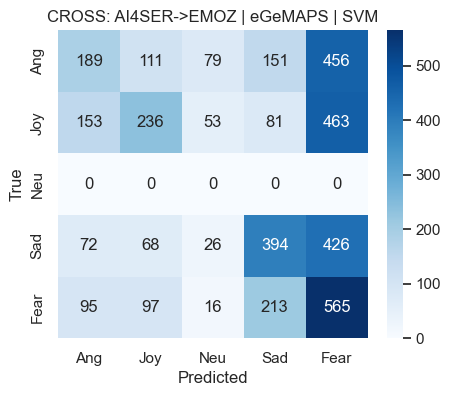


--- REPORT: CROSS: EMOZ->AI4SER | eGeMAPS | SVM (Acc: 0.30) ---
              precision    recall  f1-score   support

         Ang       0.27      0.31      0.29       500
         Joy       0.26      0.80      0.39       500
         Neu       0.00      0.00      0.00       500
         Sad       0.52      0.30      0.38       500
        Fear       0.49      0.09      0.15       500

    accuracy                           0.30      2500
   macro avg       0.31      0.30      0.24      2500
weighted avg       0.31      0.30      0.24      2500



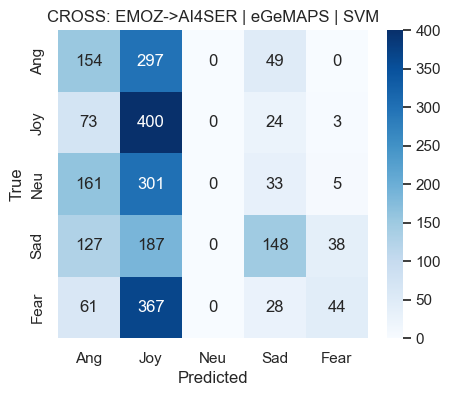

⚙️ Running: CROSS | MLP ...

--- REPORT: CROSS: AI4SER->EMOZ | eGeMAPS | MLP (Acc: 0.29) ---
              precision    recall  f1-score   support

         Ang       0.36      0.04      0.08       986
         Joy       0.60      0.13      0.21       986
         Neu       0.00      0.00      0.00         0
         Sad       0.44      0.18      0.25       986
        Fear       0.27      0.81      0.40       986

    accuracy                           0.29      3944
   macro avg       0.33      0.23      0.19      3944
weighted avg       0.42      0.29      0.24      3944



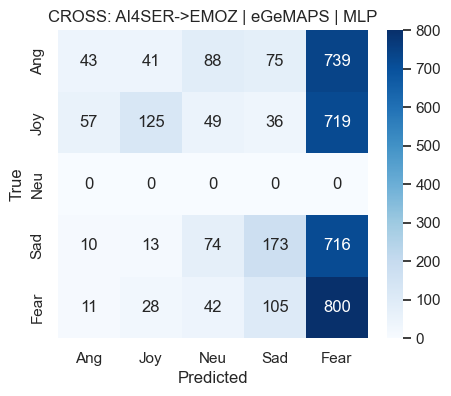


--- REPORT: CROSS: EMOZ->AI4SER | eGeMAPS | MLP (Acc: 0.28) ---
              precision    recall  f1-score   support

         Ang       0.10      0.08      0.09       500
         Joy       0.26      0.96      0.41       500
         Neu       0.00      0.00      0.00       500
         Sad       0.68      0.24      0.36       500
        Fear       0.54      0.10      0.17       500

    accuracy                           0.28      2500
   macro avg       0.32      0.28      0.20      2500
weighted avg       0.32      0.28      0.20      2500



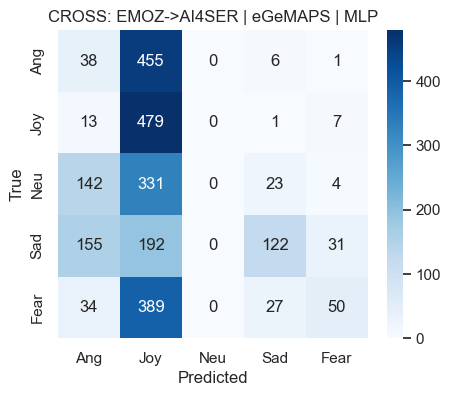

SCENARIO 3: COMBINED DATASET (MLP)

⚙️ Running: COMBINED | MLP ...

--- REPORT: COMBINED: All Data | MLP (Acc: 0.66) ---
              precision    recall  f1-score   support

         Ang       0.65      0.66      0.66      1486
         Joy       0.65      0.66      0.65      1486
         Neu       0.73      0.80      0.76       500
         Sad       0.68      0.68      0.68      1486
        Fear       0.62      0.58      0.60      1486

    accuracy                           0.66      6444
   macro avg       0.67      0.68      0.67      6444
weighted avg       0.66      0.66      0.66      6444



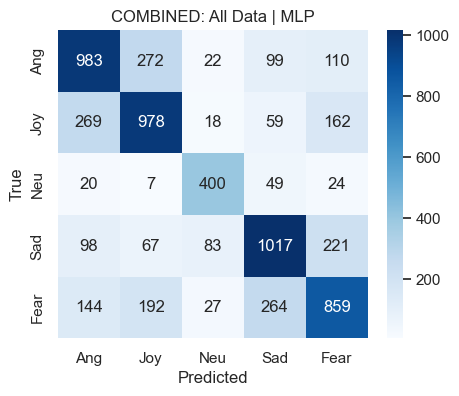


Addestramento Rete Neurale su 100% dei dati per analisi dettaglio...

--- PERFORMANCE DEL MODELLO 'UNIVERSALE' SU SINGOLI DATASET ---

--- REPORT: MLP Combined -> Testato su AI4SER (Acc: 0.84) ---
              precision    recall  f1-score   support

         Ang       0.82      0.82      0.82       500
         Joy       0.81      0.81      0.81       500
         Neu       0.90      0.85      0.87       500
         Sad       0.88      0.88      0.88       500
        Fear       0.80      0.84      0.82       500

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500



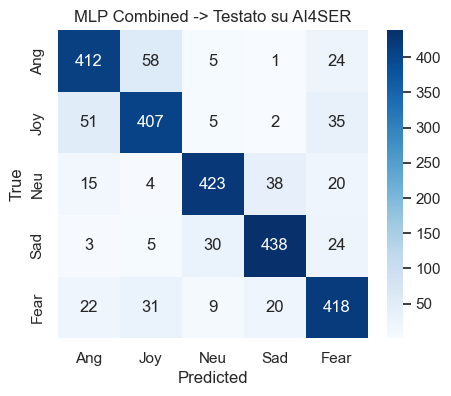


--- REPORT: MLP Combined -> Testato su EMOZIONALMENTE (Acc: 0.77) ---
              precision    recall  f1-score   support

         Ang       0.80      0.72      0.76       986
         Joy       0.77      0.78      0.78       986
         Neu       0.00      0.00      0.00         0
         Sad       0.77      0.83      0.79       986
        Fear       0.74      0.74      0.74       986

    accuracy                           0.77      3944
   macro avg       0.62      0.62      0.61      3944
weighted avg       0.77      0.77      0.77      3944



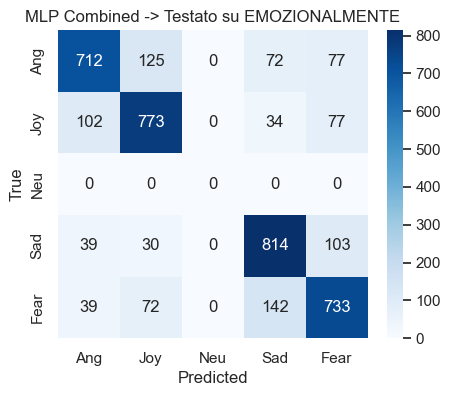

In [7]:
# main experiment execution

models = ['svm', 'mlp'] 
features = {'MFCC': X_mfcc, 'eGeMAPS': X_egemaps}

# INTRA-DATASET
print("SCENARIO 1: INTRA-DATASET (5-Fold CV)\n")

for ds in ['AI4SER', 'EMOZIONALMENTE']:
    for f_name, X_data in features.items():
        for m in models:
            res = run_experiment(X_data, y, groups, scenario=ds, model_type=m)
            plot_cm(res['y_true'], res['y_pred'], f"INTRA: {ds} | {f_name} | {m.upper()}")

# CROSS-DATASET
print("SCENARIO 2: CROSS-DATASET (eGeMAPS only)\n")

for m in models:
    res = run_experiment(X_egemaps, y, groups, scenario='CROSS', model_type=m)
    
    plot_cm(res['A_to_B']['y_true'], res['A_to_B']['y_pred'], 
            f"CROSS: AI4SER->EMOZ | eGeMAPS | {m.upper()}")
    
    plot_cm(res['B_to_A']['y_true'], res['B_to_A']['y_pred'], 
            f"CROSS: EMOZ->AI4SER | eGeMAPS | {m.upper()}")

# COMBINED
print("SCENARIO 3: COMBINED DATASET (MLP)\n")

best_feat = X_egemaps

res_comb = run_experiment(best_feat, y, groups, scenario='COMBINED', model_type='mlp')
plot_cm(res_comb['y_true'], res_comb['y_pred'], "COMBINED: All Data | MLP")

print("\nAddestramento Rete Neurale su 100% dei dati per analisi dettaglio...")
clf_final = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500, early_stopping=True, random_state=42)
scaler_final = StandardScaler()

X_scaled = scaler_final.fit_transform(best_feat)
clf_final.fit(X_scaled, y)

print("\n--- PERFORMANCE DEL MODELLO 'UNIVERSALE' SU SINGOLI DATASET ---")

# AI4SER testing
mask_ai = groups == 'AI4SER'
y_pred_ai = clf_final.predict(X_scaled[mask_ai])
plot_cm(y[mask_ai], y_pred_ai, "MLP Combined -> Testato su AI4SER")

# EMOZIONALMENTE testing
mask_em = groups == 'EMOZIONALMENTE'
y_pred_em = clf_final.predict(X_scaled[mask_em])
plot_cm(y[mask_em], y_pred_em, "MLP Combined -> Testato su EMOZIONALMENTE")